In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import pandas as pd
from scipy.integrate import odeint
from scipy.interpolate import interp1d

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [4]:
datagfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#GFP_corrected")
datarfp = pd.read_excel("data/2017_06_02_seq4_Huh7_siRNA_#molecules.xlsx",sheet_name="#RFP")

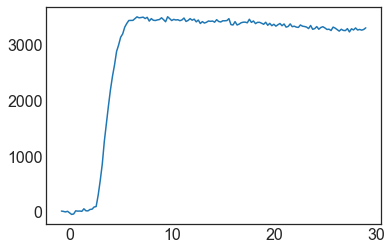

In [5]:
plt.plot(datagfp["Time [h]"],datagfp["#10^3 molecules eGFP crosstalk corrected.2"])

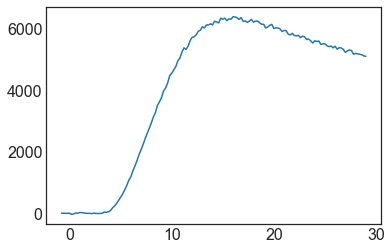

In [9]:
t = np.array(datarfp["Time [h]"])
tt = np.array(datarfp["Time [h]"])
data = datarfp["#10^3 molecules CayRFP.2"]
noise = np.sqrt(np.abs(data))
plt.plot(t,data)

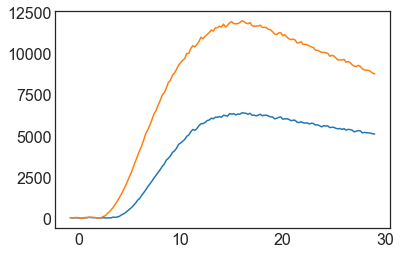

In [11]:
t2 = np.array(datarfp["Time [h]"])
tt2 = np.array(datarfp["Time [h]"])
data2 = datarfp["#10^3 molecules CayRFP.4"]
noise = np.sqrt(np.abs(data))
plt.plot(t,data)
plt.plot(t2,data2)

In [17]:
t2

array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
        1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,
        3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,
        5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,
        8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ,
       10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2,
       12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4,
       14.6, 14.8, 15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6,
       16.8, 17. , 17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8,
       19. , 19.2, 19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8, 21. ,
       21.2, 21.4, 21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8, 23. , 23.2,
       23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. , 25.2, 25.4,
       25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2, 27.4, 27.6,
       27.8, 28. , 28.2, 28.4, 28.6, 28.8, 29. ])

In [21]:
y1 = interp1d(t,data,kind='cubic')
y2 = interp1d(t2,data2,kind='cubic')

In [30]:
tr1 = 4.5
tr2 = 3
t_new = np.arange(0,20.2,0.2)
data2_new = y2(t_new+tr2)
data_new = y1(t_new+tr1)

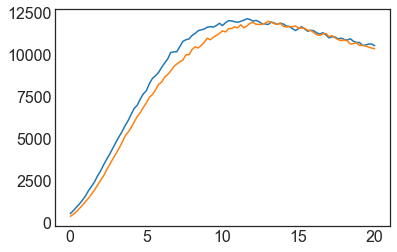

In [35]:
plt.plot(t_new,data_new*1.9)
plt.plot(t_new,data2_new)


In [7]:
def DE(t, t0, m, k, beta, delta, offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset

In [8]:
# solve the ODE directly
def gfp(y,t,m,k,beta,delta):
    dydt = [-delta*y[0],
            m*y[0]-(beta+k)*y[1],
            k*y[1]-beta*y[2]]
    return dydt

def DEODE(t, t0, m, k, beta, delta, offset):
    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0
    if dt[0]>0:
        addzero = True
        dt = np.concatenate(([0.0],dt))
    else:
        addzero = False
    result = odeint(gfp, [1.0,0.0,0.0], dt, args=(m,k,beta,delta))
    if addzero:
        f[idx_after] = result[:,2][1:]
    else:
        f[idx_after] = result[:,2]

    return f + offset

def DEODE(t, t0, m, k, beta, delta, offset):
    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0
    if dt[0]>0:
        addzero = True
        dt = np.concatenate(([0.0],dt))
    else:
        addzero = False
    result = odeint(gfp, [1.0,0.0,0.0], dt, args=(m,k,beta,delta))
    if addzero:
        f[idx_after] = result[:,2][1:]
    else:
        f[idx_after] = result[:,2]

    return f + offset

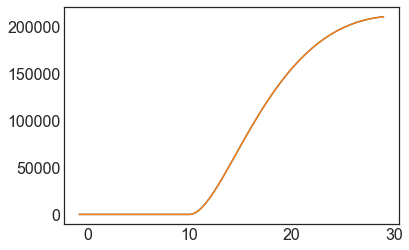

In [9]:
m_ktl_0 = 4e4

tr_0 = 4.5
kmr_0 = 0.3
betr_0 = 0.0421
deltr_0 = 0.08
offr_0 = 0

y = DEODE(t,10,m_ktl_0,kmr_0,betr_0,deltr_0,0)
y1 = DE(t,10,m_ktl_0,kmr_0,betr_0,deltr_0,0)
plt.plot(t,y)
plt.plot(t,y1)
#print(t,y)

In [10]:
m_ktl_0 = 2e4

tr_0 = 4.5
kmr_0 = 0.3
betr_0 = 0.0421
deltr_0 = 0.03
offr_0 = 0

DE_model = lm.Model(DEODE)
pars = DE_model.make_params()
pars['t0'].set(value=tr_0,vary=True)
pars['m'].set(value=m_ktl_0,vary=True)
pars['k'].set(value=kmr_0,vary=False)
pars['beta'].set(value=betr_0,vary=False)
pars['delta'].set(value=deltr_0,vary=True)
pars['offset'].set(value=offr_0,vary=True)

out = DE_model.fit(data, pars, t=tt, weights=1/noise)
print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(DEODE)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 150
    # variables        = 4
    chi-square         = 780.974985
    reduced chi-square = 5.34914374
    Akaike info crit   = 255.486174
    Bayesian info crit = 267.528715
[[Variables]]
    t0:      3.58068238 +/- 0.02828746 (0.79%) (init = 4.5)
    m:       2352.11525 +/- 33.5344160 (1.43%) (init = 20000)
    k:       0.3 (fixed)
    beta:    0.0421 (fixed)
    delta:   0.20469384 +/- 0.00342097 (1.67%) (init = 0.03)
    offset:  0.87443004 +/- 0.68056426 (77.83%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(m, delta)  =  0.977
    C(t0, m)     =  0.735
    C(t0, delta) =  0.714


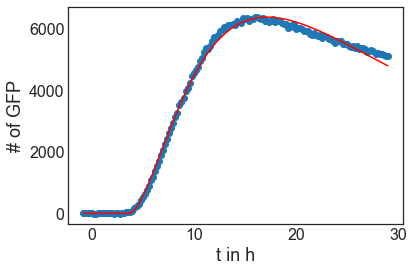

In [15]:
plt.plot(t,data,"o")
plt.plot(t, out.best_fit, 'r-')
plt.xlabel("t in h")
plt.ylabel("# of GFP")
plt.savefig("lq-fitted.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [13]:
import pymc3 as pm

In [ ]:
m_ktl_0 = 2e4
m_ktl_max = 5e5

tr_0 = 4.5

kmr_0 = 0.3
kmr_sigma = 0.08

betr_0 = 0.0421
betr_sigma = 0.013

deltr_0 = 0.03
offr_0 = 0


t0 = pm.Uniform('t0',lower=0,upper=20)
m = pm.Uniform('m',lower = 1, upper = m_ktl_max)
k = pm.Uniform('k',lower = 0, upper = kmr_0*5)
beta = pm.Uniform('beta',lower =0, upper = betr_0*5)
delta = pm.Uniform('delta',lower=0,upper=1)
offset = pm.Uniform('offset',lower=0,upper=50.0)

@pm.deterministic
def DE_pm(t=tt, t0=t0, m=m, k=k, beta=beta, delta=delta, offset=offset):
    """General expression model function"""

    f = np.zeros(np.shape(t))
    idx_after = np.array(t > t0, dtype = bool)
    dt = t[idx_after] - t0

    f1 = np.exp(- (beta + k) * dt) / (beta - delta + k)
    f2 = - np.exp(- beta * dt) / (beta - delta)
    f3 = k * np.exp(- delta * dt) / (beta - delta) / (beta - delta + k)

    f[idx_after] = (f1 + f2 + f3) * m

    return f + offset

obs = pm.Normal('obs', mu=DE_pm, tau=1/noise**2, observed=True,
                value=data)

In [ ]:
SAMPLES = 100000
BURN = 50000

model = pm.Model([t0, m, k, beta, delta,offset,obs])
mcmc = pm.MCMC(model)
mcmc.sample(SAMPLES + BURN, BURN)

plt.hist(mcmc.trace('t0')[:])

In [ ]:
pm.Matplot.plot(mcmc)

In [ ]:
mcmc.summary()

In [ ]:
t_eq = 40000
print("delta: ",np.percentile(mcmc.trace('delta')[t_eq:],[2.5,25,50,75,97.5]))
print("k: ",np.percentile(mcmc.trace('k')[t_eq:],[2.5,25,50,75,97.5]))
print("beta: ",np.percentile(mcmc.trace('beta')[t_eq:],[2.5,25,50,75,97.5]))
print("m: ",np.percentile(mcmc.trace('m')[t_eq:],[2.5,25,50,75,97.5]))
print("offset: ",np.percentile(mcmc.trace('offset')[t_eq:],[2.5,25,50,75,97.5]))
print("t0: ",np.percentile(mcmc.trace('t0')[t_eq:],[2.5,25,50,75,97.5]))

In [ ]:
MC_fit = DE(t=tt,
            t0=mcmc.trace('t0')[t_eq:].mean(),
           beta=mcmc.trace('beta')[t_eq:].mean(),
           delta=mcmc.trace('delta')[t_eq:].mean(),
            k=mcmc.trace('k')[t_eq:].mean(),
            m=mcmc.trace('m')[t_eq:].mean(),
            offset=mcmc.trace('offset')[t_eq:].mean()
           )
plt.plot(tt,data,"o")
plt.plot(tt,MC_fit)